In [1]:
import cv2
from cv2 import VideoCapture
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
from typing import *

# Convert video to image frames


In [2]:
def video2frames(vid_path: str, save_path: str) -> None:
    """Convert videos to frame and save frames.

    Args:
        vid_path: path to video
        save_path: path to save frames to
    """
    assert save_path[-1] == "/", f"Requires a directory, {save_path} must end in '/'"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    while success:
        # save frame as JPEG file
        cv2.imwrite(save_path + f"{count}.jpg", image)
        success, image = vidcap.read()
        count += 1
    print(f"Saved {count} frames to {save_path}.")
    vidcap.release()


In [3]:
vid_paths = [
    # "./data/Records/bfmc2020_online_1.avi",
    "./data/Records/bfmc2020_online_2.avi",
    # "./data/Records/bfmc2020_online_3.avi",
    # "./data/Records/home.mp4",
]
path = f"./data/bfmc2020/frames_3/"

# video2frames(vid_paths[0], path)


## Import converted image frames


In [4]:
def import_images(path: str) -> List[np.ndarray]:
    """Import all the images of a given directory path and return an array of images

    Args:
        path:(str) path to dir (Make sure path ends in a /)

    Returns:List[np.ndarray] List of images.

    """
    assert path[-1] == "/", f"Requires a directory, {path} must end in a '/'"

    # get file names of frames
    col_frames = os.listdir(path)
    col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

    # load frames
    col_images = []
    for i in tqdm(col_frames):
        img = cv2.imread(path + i)
        col_images.append(img)
    return col_images


path = "./data/bfmc2020/frames_3/"
col_images = import_images(path)
len(col_images)


100%|██████████| 2163/2163 [00:57<00:00, 37.88it/s]


2163

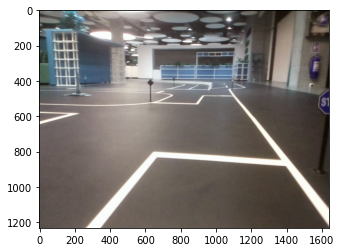

In [5]:
plt.imshow(col_images[200])


## Intersection Detection


In [6]:
def persepective_wrap(img: np.ndarray) -> np.ndarray:
    """ROI of image and Perform perspective wrapping on the image"""
    roi = [
        (0.2 * ((img.shape[1] - 1)), 0.55 * (img.shape[0] - 1)),
        (0.8 * ((img.shape[1] - 1)), 0.55 * (img.shape[0] - 1)),
        (0 * ((img.shape[1] - 1)), img.shape[0] - 1),
        (1 * ((img.shape[1] - 1)), img.shape[0] - 1),
    ]
    # Get image size
    img_size = (img.shape[1], img.shape[0])
    # Perspective points to be warped
    src = np.float32(roi)
    # Window to be shown
    dst = np.float32(
        [[0, 0], [img.shape[1], 0], [0, img.shape[0]], [img.shape[1], img.shape[0]]]
    )

    # Matrix to warp the image for birdseye window
    matrix = cv2.getPerspectiveTransform(src, dst)
    # Inverse matrix to unwarp the image for final window
    minv = cv2.getPerspectiveTransform(dst, src)
    birdseye = cv2.warpPerspective(img, matrix, img_size)

    return birdseye


In [31]:
def roi_func(img: np.ndarray) -> np.ndarray:
    """Given image get Region of interest

    Args:
        img: (np.ndarray) input image

    Returns:
        np.ndarray: the roi image
    """
    # create stencil just the first time and then save for later use
    roi = [
                (
                    int(0.1 * ((img.shape[1] - 1))),
                    int(0.55 * (img.shape[0] - 1)),
                ),
                (int(0 * ((img.shape[1] - 1))), int(img.shape[0] - 1)),
                (int(1 * ((img.shape[1] - 1))), int(img.shape[0] - 1)),
                (
                    int(0.9 * ((img.shape[1] - 1))),
                    int(0.55 * (img.shape[0] - 1)),
                ),
            ]
    stencil = np.zeros_like(img, dtype="uint8")
        # specify coordinates of the polygon
    polygon = np.array(roi)
        # fill polygon with ones
    cv2.fillConvexPoly(stencil, polygon, [255, 255, 255])
    # plt.imshow(stencil)

    img = cv2.bitwise_and(img, img, mask=stencil[:, :])
    return img


def roi_func_persp(img: np.ndarray) -> np.ndarray:
    """Given image get Region of interest

    Args:
        img: (np.ndarray) input image

    Returns:
        np.ndarray: the roi image
    """
    # create stencil just the first time and then save for later use
    roi = [
            (
                int(0.25 * ((img.shape[1] - 1))),
                int((img.shape[0] - 1)),
            ),
            (int(0.75 * ((img.shape[1] - 1))),int(0.55*(img.shape[0] - 1))),
            (int(1 * ((img.shape[1] - 1))),int(0.55*(img.shape[0] - 1))),
            (
                int(1 * ((img.shape[1] - 1))),
                int(0.20 * (img.shape[0] - 1)),
            ),
        ]
    stencil = np.zeros_like(img, dtype="uint8")
        # specify coordinates of the polygon
    polygon = np.array(roi)
        # fill polygon with ones
    cv2.fillConvexPoly(stencil, polygon, [255, 255, 255])

    img = cv2.bitwise_and(img, img, mask=stencil[:, :])
    return img



In [32]:
def intersection_det(img, area_threshold=20_000) -> np.ndarray:
    # preprocess
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lower_white = np.array([90, 90, 90])
    upper_white = np.array([255, 255, 255])
    mask = cv2.inRange(img, lower_white, upper_white)
    hls_result = cv2.bitwise_and(img, img, mask=mask)
    # Convert image to grayscale, apply threshold, blur & extract edges
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
    blur = cv2.GaussianBlur(thresh, (7, 7), 0)
    roi = roi_func(blur)
    # persp = persepective_wrap(blur)
    # roi_persp = roi_func_persp(persp)

    # detect horizontal lines
    result = img.copy()
    horizontal_size = blur.shape[1] // 10
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size,10))
    detect_horizontal = cv2.morphologyEx(roi, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area > area_threshold:
            cv2.drawContours(result, [c], -1, (255,0,0), 5)
    return roi, detect_horizontal, result

# plt.imshow(intersection_det(col_images[350]))


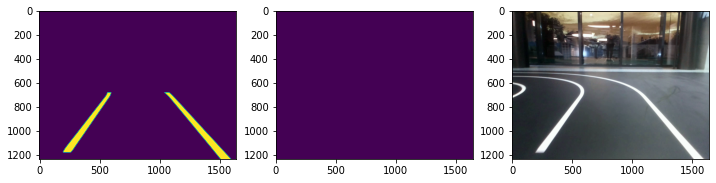

In [33]:
idx = 1550
img = col_images[idx]
roi,det, out_img = intersection_det(img)
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,8) )
ax1.imshow(roi)
ax2.imshow(det)
ax3.imshow(out_img)
#plt.imshow(out_img)


In [34]:
# def h_det(img:np.ndarray) -> np.ndarray:
#     result = img.copy()
#     result = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)
#     plt.imshow(result)
#     horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
#     detect_horizontal = cv2.morphologyEx(img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
#     plt.imshow(detect_horizontal)
#     cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if len(cnts) == 2 else cnts[1]
#     for c in cnts:
#         cv2.drawContours(result, [c], -1, (255,0,0), 5)
#     return result

# _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
# ax1.imshow(h_det(roi_persp))
# ax2.imshow(h_det(roi))


In [35]:
# def det_intersection(img: np.ndarray, area_threshold: float = 20_000):
#     """Detect Intersection line in the image

#     Args:
#         img: input image
#         area_threshold: request area threshold for detection

#     Returns:
#         detected:(bool) if intersection line is detected
#         out_img:(np.ndaarray) image with box around intersection line
#     """
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     blurred = cv2.GaussianBlur(gray, (15, 15), 6)
#     ret, thresh = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY)

#     contours, hier = cv2.findContours(
#         thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
#     )
#     out_img = img.copy()
#     detected = False

#     for c in contours:
#         area = cv2.contourArea(c)
#         if area > area_threshold:
#             detected = True
#             rect = cv2.minAreaRect(c)
#             box = cv2.boxPoints(rect)
#             # convert all coordinates floating point values to int
#             box = np.int0(box)
#             # draw a red 'nghien' rectangle
#             cv2.drawContours(out_img, [box], 0, (255, 0, 0), 2)
#     return detected, out_img


### Intersection detection on images


### Intersection detection of video


In [36]:
def process_video(video_path: str, out_path: str):
    cap = cv2.VideoCapture(video_path)
    out = None
    count = 0
    while cap.isOpened():
        # try:
        ret, frame = cap.read()
        image = frame
        if out == None:
            h, w, _ = image.shape
            out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"DIVX"), 15, (w, h))

        if not ret or cv2.waitKey(1) == 27:
            break

        _,_,out_img = intersection_det(image)

        out.write(out_img)
        count += 1
    print(f"No. of frames : {count}")
    cap.release()
    cv2.destroyAllWindows()


In [37]:
process_video("./data/Records/bfmc2020_online_2.avi", f"./data/intersection_det.avi")


No. of frames : 2002
